In [1]:
!pip install split-folders imutils

  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25834 sha256=9e142efdcb9921bacc8b940ccb2231a56608e8a1342d65694d331e8875028a50
  Stored in directory: /root/.cache/pip/wheels/85/cf/3a/e265e975a1e7c7e54eb3692d6aa4e2e7d6a3945d29da46f2d7
Successfully built imutils


# Import needed libraries
To make things work ensure that you have this libraries installed.

In [3]:
# imports
import os
import splitfolders
import tensorflow as tf
from typing import Tuple, List
from string import digits
from imutils import paths
from random import choices
from tensorflow.data import AUTOTUNE
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Bidirectional, InputLayer, Reshape
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.losses import CategoricalCrossentropy
import seaborn as sns

# Helper functions
The following functions are helpful tools for visualising model training progress and evaluating model performance through confusion matrix analysis.

In [4]:
def plot_history(history, metric: str = '', ylim: List[float] | None = None):
    h = history.history
    plt.figure(figsize=(15,5))
    plt.plot(h[metric])
    plt.plot(h[f'val_{metric}'])
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend([metric, f'val_{metric}'], loc='upper left')
    if ylim:
        axes = plt.gca()
        axes.set_ylim(ylim)
    plt.show()
    
def show_confusion_matrix(y_true, y_pred, labels: List[str] = []):
    matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(len(labels), len(labels)))
    hm = sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=labels,
                yticklabels=labels,
                annot=True,
                fmt='d')
    plt.yticks(rotation = 0)
    hm.set_ylim(0, len(matrix))
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Data
The Dataset class is designed as a helper tool for loading and preparing image datasets for training machine learning models.

In [5]:
class Dataset:
    def __init__(self, path: str, output: str | None = None, ratio: Tuple[float, float, float] = (.70, .15, .15), split: bool = True, image_size: Tuple[int, int] = (224,224), batch_size: int = 8):
        self.path = path
        self.labels = [name for name in os.listdir(self.path) if os.path.isdir(os.path.join(self.path, name))]

        self.ratio = ratio
        
        self.output_path = output if output else f"./data-{''.join(choices(digits, k=5))}"
        
        self.train = os.path.sep.join([self.output_path, 'train'])
        self.val = os.path.sep.join([self.output_path, 'val'])
        self.test = os.path.sep.join([self.output_path, 'test'])
        
        self.image_size = image_size
        self.batch_size = batch_size
        
        if split:
            self.__split_folder()
            
        self.__generate()
        
    def __split_folder(self):
        splitfolders.ratio(self.path, output=self.output_path, seed=42, ratio=self.ratio, group_prefix=None)
    
    def __generate(self):
        def load_images(image_path):
            image = tf.io.read_file(image_path)
            image = tf.image.decode_png(image, channels=3)
            image = tf.image.convert_image_dtype(image, dtype=tf.float32)
            image = tf.image.resize(image, self.image_size)
            
            label = tf.strings.split(image_path, os.path.sep)[-2]
            label = tf.cast(tf.equal(self.labels, label), tf.int32)
    
            return (image, label)
        
        train_paths = list(paths.list_images(self.train))
        self.train_len = len(train_paths)
        self.train = tf.data.Dataset.from_tensor_slices(train_paths)
        self.train = (self.train
            .shuffle(len(train_paths), reshuffle_each_iteration=True)
            .map(load_images, num_parallel_calls=AUTOTUNE)
            .cache()
            .batch(self.batch_size)
            .repeat(-1)
            .prefetch(AUTOTUNE)
        )
        
        val_paths = list(paths.list_images(self.val))
        self.val_len = len(val_paths)
        self.val = tf.data.Dataset.from_tensor_slices(val_paths)
        self.val = (self.val
            .shuffle(len(val_paths))
            .map(load_images, num_parallel_calls=AUTOTUNE)
            .cache()
            .batch(self.batch_size)
            .repeat(-1)
            .prefetch(AUTOTUNE)
        )
        
        test_paths = list(paths.list_images(self.test))
        self.test_len = len(test_paths)
        self.test = tf.data.Dataset.from_tensor_slices(test_paths)
        self.test = (self.test
            .map(load_images, num_parallel_calls=AUTOTUNE)
            .cache()
            .batch(self.batch_size)
            .prefetch(AUTOTUNE)
        )

# Xception
The *build_model* method is used to build model based on [Xception network](https://arxiv.org/abs/1610.02357) with added custom dense layers. The **STFT** and **Mel Spectrogram** are used to learn this model.

In [6]:
def build_model(height: int = 224, width: int = 224, channels: int = 3):
    input_shape = (channels, height, width) if  K.image_data_format() == 'channels_first' else (height, width, channels)
    
    # Create the model
    model = Sequential()
    model.add(tf.keras.applications.Xception(include_top=False,
                                           weights=None,
                                           input_shape=input_shape,
                                           pooling='max'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    
    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss=CategoricalCrossentropy(),
        metrics=[
            CategoricalAccuracy(name='accuracy')
        ])
    
    return model

# Short-Time Fourier Transform

In [12]:
model = build_model()

In [13]:
batch_size = 8
dataset = Dataset(path='/kaggle/input/musicgenreprediction/Data/images_augmented/stft', batch_size=batch_size)

Copying files: 4995 files [00:11, 424.16 files/s]


In [14]:
epochs = 20
batch_size = 8

# Train the model using generator for training data and validation data
history = model.fit(dataset.train,
                    batch_size=batch_size,
                    epochs=epochs,
                    steps_per_epoch=dataset.train_len // 8,
                    validation_data=dataset.val,
                    validation_steps=dataset.val_len // 8,
                    verbose=1)

Epoch 1/20
  1/437 ━━━━━━━━━━━━━━━━━━━━ 4:35:27 38s/step - accuracy: 0.0000e+00 - loss: 3.8565

W0000 00:00:1712741551.137226      99 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


437/437 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.3329 - loss: 1.9090

W0000 00:00:1712741605.026284     100 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


437/437 ━━━━━━━━━━━━━━━━━━━━ 95s 130ms/step - accuracy: 0.3331 - loss: 1.9083 - val_accuracy: 0.0981 - val_loss: 2.3061
Epoch 2/20
437/437 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.6635 - loss: 0.9598

W0000 00:00:1712741658.612107      99 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


437/437 ━━━━━━━━━━━━━━━━━━━━ 53s 122ms/step - accuracy: 0.6636 - loss: 0.9594 - val_accuracy: 0.6829 - val_loss: 0.9262
Epoch 3/20
437/437 ━━━━━━━━━━━━━━━━━━━━ 52s 119ms/step - accuracy: 0.9242 - loss: 0.3132 - val_accuracy: 0.7166 - val_loss: 0.9528
Epoch 4/20
437/437 ━━━━━━━━━━━━━━━━━━━━ 52s 119ms/step - accuracy: 0.9916 - loss: 0.0760 - val_accuracy: 0.7557 - val_loss: 0.8110
Epoch 5/20
437/437 ━━━━━━━━━━━━━━━━━━━━ 52s 119ms/step - accuracy: 0.9972 - loss: 0.0291 - val_accuracy: 0.7436 - val_loss: 0.9323
Epoch 6/20
437/437 ━━━━━━━━━━━━━━━━━━━━ 52s 119ms/step - accuracy: 0.9966 - loss: 0.0236 - val_accuracy: 0.7611 - val_loss: 0.8285
Epoch 7/20
437/437 ━━━━━━━━━━━━━━━━━━━━ 52s 119ms/step - accuracy: 0.9984 - loss: 0.0121 - val_accuracy: 0.7746 - val_loss: 0.8306
Epoch 8/20
437/437 ━━━━━━━━━━━━━━━━━━━━ 52s 119ms/step - accuracy: 0.8899 - loss: 0.3535 - val_accuracy: 0.6478 - val_loss: 1.3480
Epoch 9/20
437/437 ━━━━━━━━━━━━━━━━━━━━ 52s 119ms/step - accuracy: 0.8817 - loss: 0.3506 - val

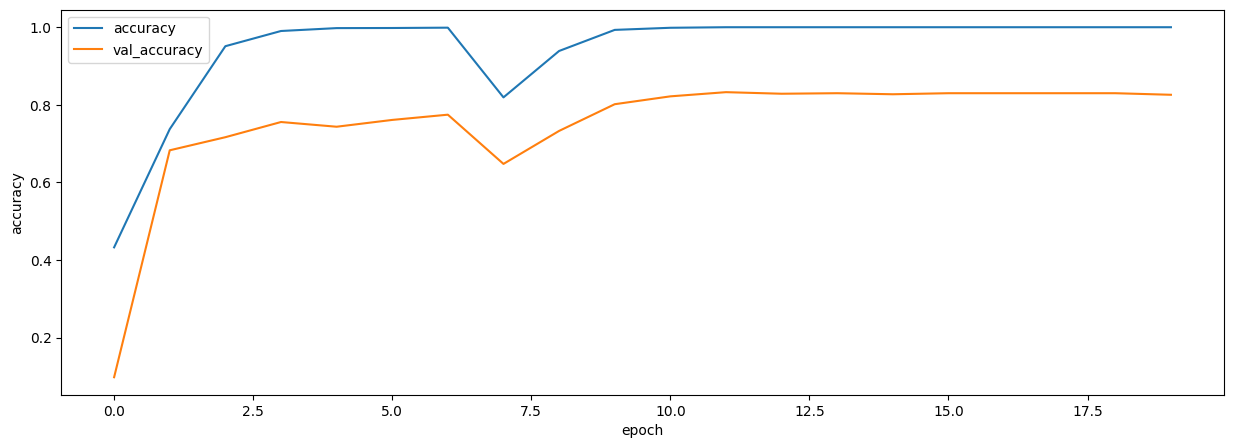

In [15]:
plot_history(history, metric='accuracy')

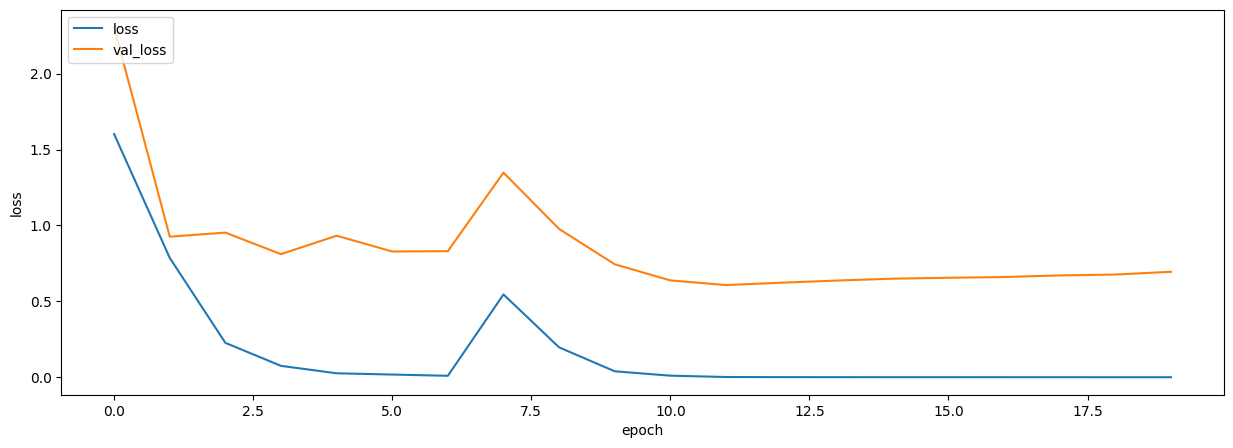

In [16]:
plot_history(history, metric='loss')

In [19]:
evaluation = model.evaluate(dataset.test, return_dict=True)
print(f'Accuracy: {evaluation["accuracy"]}')
print(f'Loss: {evaluation["loss"]}')

94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - accuracy: 0.8227 - loss: 0.6273
Accuracy: 0.8453333377838135
Loss: 0.563007652759552


W0000 00:00:1712742678.620513     100 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step


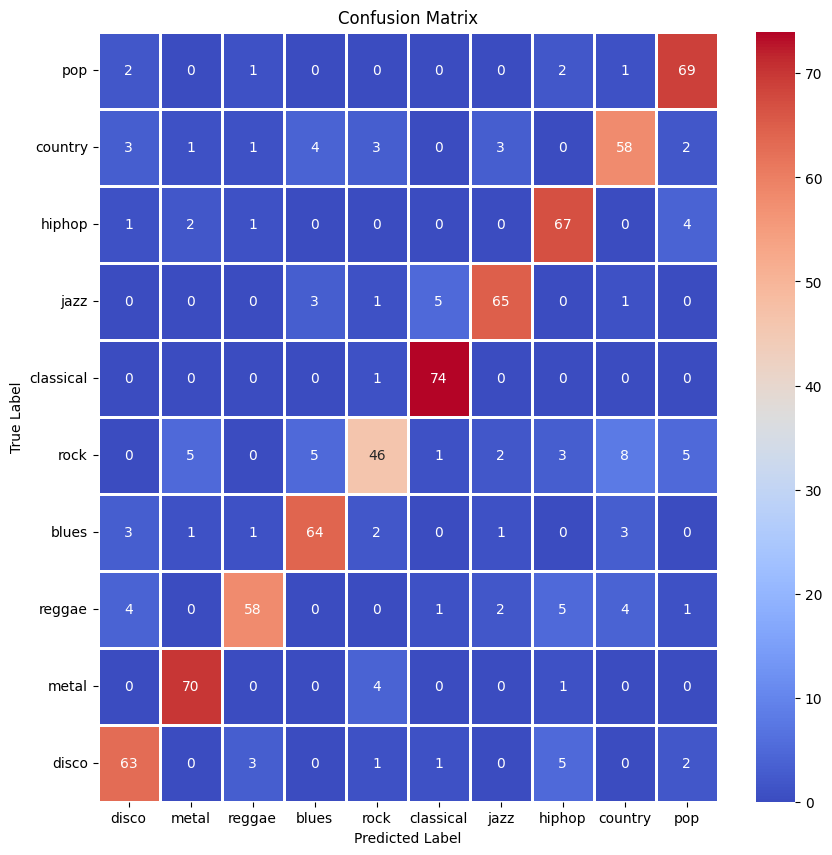

              precision    recall  f1-score   support

           0       0.83      0.84      0.83        75
           1       0.89      0.93      0.91        75
           2       0.89      0.77      0.83        75
           3       0.84      0.85      0.85        75
           4       0.79      0.61      0.69        75
           5       0.90      0.99      0.94        75
           6       0.89      0.87      0.88        75
           7       0.81      0.89      0.85        75
           8       0.77      0.77      0.77        75
           9       0.83      0.92      0.87        75

    accuracy                           0.85       750
   macro avg       0.84      0.85      0.84       750
weighted avg       0.84      0.85      0.84       750



In [22]:
y_pred = model.predict(dataset.test)
y_pred = np.argmax(y_pred, axis=1)
y_true = tf.concat([y for x, y in dataset.test], axis=0).numpy().argmax(axis=1)

show_confusion_matrix(y_true, y_pred, labels=dataset.labels)
print(classification_report(y_true, y_pred))

# Mel Spectogram

In [23]:
batch_size = 8
dataset = Dataset(path='/kaggle/input/musicgenreprediction/Data/images_augmented/mel_spectrogram', batch_size=batch_size)

Copying files: 4995 files [00:39, 125.04 files/s]


In [24]:
model = build_model()

epochs = 20
batch_size = 8

# Train the model using generator for training data and validation data
history = model.fit(dataset.train,
                    batch_size=batch_size,
                    epochs=epochs,
                    steps_per_epoch=dataset.train_len // 8,
                    validation_data=dataset.val,
                    validation_steps=dataset.val_len // 8,
                    verbose=1)

Epoch 1/20
  1/437 ━━━━━━━━━━━━━━━━━━━━ 4:48:05 40s/step - accuracy: 0.0000e+00 - loss: 3.9266

W0000 00:00:1712742818.219252      99 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


437/437 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.3153 - loss: 1.9255

W0000 00:00:1712742872.029082     100 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


437/437 ━━━━━━━━━━━━━━━━━━━━ 96s 130ms/step - accuracy: 0.3155 - loss: 1.9249 - val_accuracy: 0.1640 - val_loss: 2.3084
Epoch 2/20
437/437 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.6039 - loss: 1.1185

W0000 00:00:1712742925.647737     100 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


437/437 ━━━━━━━━━━━━━━━━━━━━ 53s 122ms/step - accuracy: 0.6040 - loss: 1.1182 - val_accuracy: 0.5938 - val_loss: 1.1604
Epoch 3/20
437/437 ━━━━━━━━━━━━━━━━━━━━ 52s 119ms/step - accuracy: 0.8429 - loss: 0.5411 - val_accuracy: 0.6788 - val_loss: 0.9866
Epoch 4/20
437/437 ━━━━━━━━━━━━━━━━━━━━ 52s 119ms/step - accuracy: 0.9751 - loss: 0.1439 - val_accuracy: 0.6559 - val_loss: 1.1343
Epoch 5/20
437/437 ━━━━━━━━━━━━━━━━━━━━ 52s 119ms/step - accuracy: 0.9945 - loss: 0.0596 - val_accuracy: 0.6883 - val_loss: 0.9895
Epoch 6/20
437/437 ━━━━━━━━━━━━━━━━━━━━ 52s 119ms/step - accuracy: 0.9951 - loss: 0.0349 - val_accuracy: 0.7341 - val_loss: 0.8749
Epoch 7/20
437/437 ━━━━━━━━━━━━━━━━━━━━ 52s 119ms/step - accuracy: 0.9977 - loss: 0.0129 - val_accuracy: 0.7665 - val_loss: 0.7971
Epoch 8/20
437/437 ━━━━━━━━━━━━━━━━━━━━ 52s 119ms/step - accuracy: 0.9948 - loss: 0.0208 - val_accuracy: 0.3482 - val_loss: 3.9723
Epoch 9/20
437/437 ━━━━━━━━━━━━━━━━━━━━ 52s 119ms/step - accuracy: 0.7152 - loss: 0.8498 - val

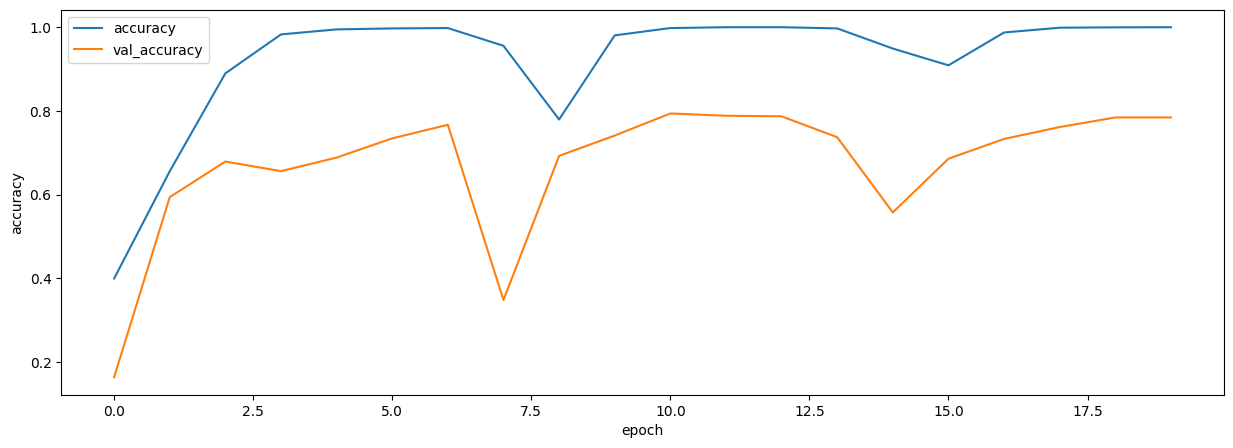

In [25]:
plot_history(history, metric='accuracy')

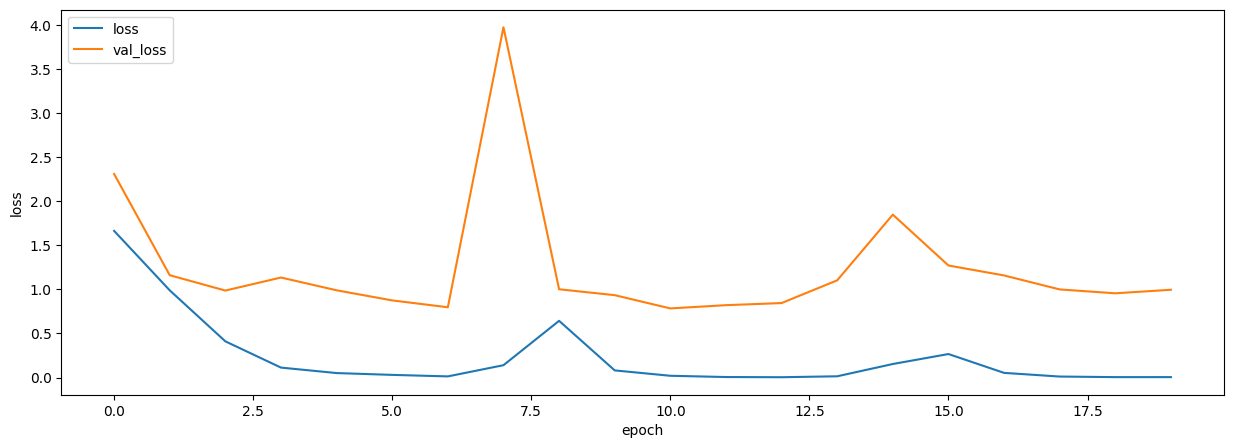

In [26]:
plot_history(history, metric='loss')

In [27]:
evaluation = model.evaluate(dataset.test, return_dict=True)
print(f'Accuracy: {evaluation["accuracy"]}')
print(f'Loss: {evaluation["loss"]}')

94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.7904 - loss: 0.7414
Accuracy: 0.8133333325386047
Loss: 0.7304238677024841


W0000 00:00:1712743933.820445     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 5/94 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step

W0000 00:00:1712743951.057706     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step


W0000 00:00:1712743956.392257     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


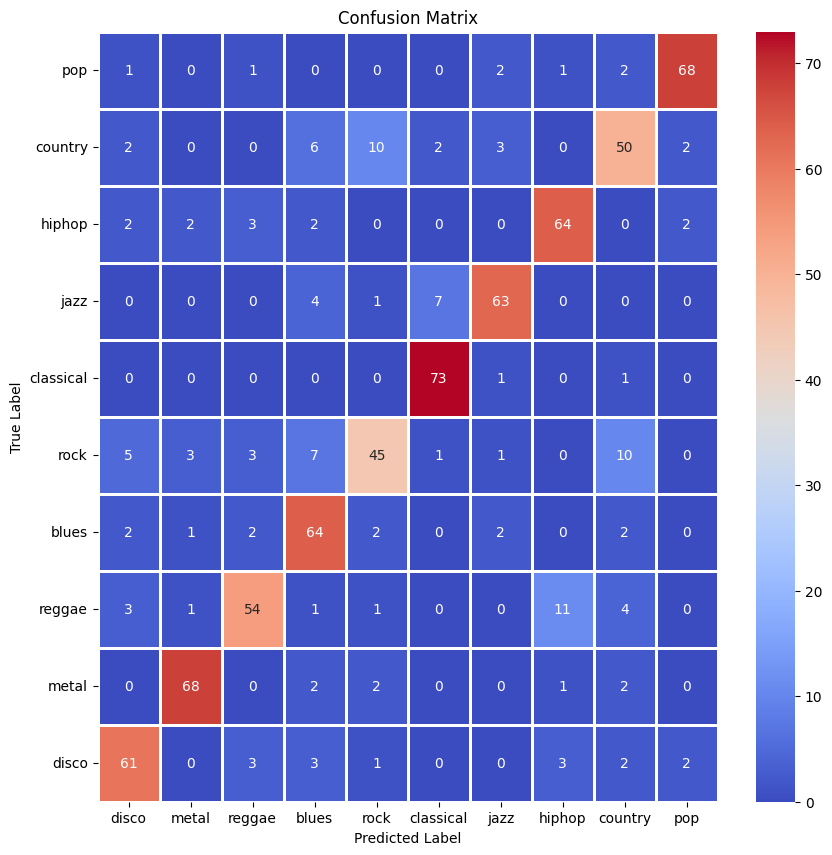

              precision    recall  f1-score   support

           0       0.80      0.81      0.81        75
           1       0.91      0.91      0.91        75
           2       0.82      0.72      0.77        75
           3       0.72      0.85      0.78        75
           4       0.73      0.60      0.66        75
           5       0.88      0.97      0.92        75
           6       0.88      0.84      0.86        75
           7       0.80      0.85      0.83        75
           8       0.68      0.67      0.68        75
           9       0.92      0.91      0.91        75

    accuracy                           0.81       750
   macro avg       0.81      0.81      0.81       750
weighted avg       0.81      0.81      0.81       750



In [29]:
y_pred = model.predict(dataset.test)
y_pred = np.argmax(y_pred, axis=1)
y_true = tf.concat([y for x, y in dataset.test], axis=0).numpy().argmax(axis=1)

show_confusion_matrix(y_true, y_pred, labels=dataset.labels)
print(classification_report(y_true, y_pred))